# Ciudades de 15 minutos - resolución 9

Notebook para la prueba de la metodología de ciudades de 15 minutos. El acercamiento del Observatorio de Ciudades se basa en agrupar las amenidades en 4 ejes:
* Educación
* Servicios comunitarios
* Comercio
* Entretenimiento

Cada uno de estos ejes se subdivide en amenidades específicas:

* Educación
    * Preescolar
    * Primaria
    * Secundaria
* Servicios comunitarios:
    * Centro de salud - lo traducimos como primer contacto a salud (que incluye farmacias con médicos)
    * Gobierno - oficinas de gobierno
    * Asistencia social - DIF
    * Cuidados - Guarderías
* Comercio:
    * Alimentos - sitios para la adquisición de alimentos
    * Comercio personal - peluquerías y venta de ropa
    * Farmacias
    * Hogar - Ferretería y tlapalería y artículos de limpieza
    * Complementario - sitios de comercio complementario como venta de ropa, calzado, muebles, lavandería, pintura y revistas
* Entretenimiento
    * Actividad física - espacios de recreación al aire libre como parques, canchas, unidades deportivas o parques naturales
    * Social - sitios de esparcimiento social como restaurantes, bares y cafés
    * Cultural - espacios de recreación cultural como museos o cines

Para calcular si un hexágono cumple o no con lo neceasrio para ser ciudad de 15 minutos se toma el tiempo máximo a una de las amenidades y esa se registra en el hexágono, si ese tiempo es menor a 15, se considera que cumple, de lo contrario no.

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Notebook config

In [2]:
city = 'ZMVM'
save_todb = True

In [3]:
if city == 'ZMVM':
    # Loads CDMX hexgrid
    hexgrid_9_cdmx = gpd.read_file("../../data/external/temporal_todocker/hexgrid_9_cdmx_selectionbycentroid.gpkg")
    # Finds hex_id codes from hex_grid (Downloads pop hex according to hex_id)
    hex_ids = str(tuple(list(hexgrid_9_cdmx["hex_id_9"].unique())))
    # Creates poly_wkt (Downloads nodes according to dissolved area)
    gdf = hexgrid_9_cdmx.to_crs("EPSG:6372")
    gdf = gdf.buffer(1).reset_index().rename(columns={0: "geometry"})
    gdf = gdf.set_geometry("geometry")
    gdf = gdf.to_crs("EPSG:4326")
    poly_wkt = gdf.dissolve().geometry.to_wkt()[0]

## Download data from database

### Download hexagons with pop data (Based on city)

(6186, 226)


<Axes: >

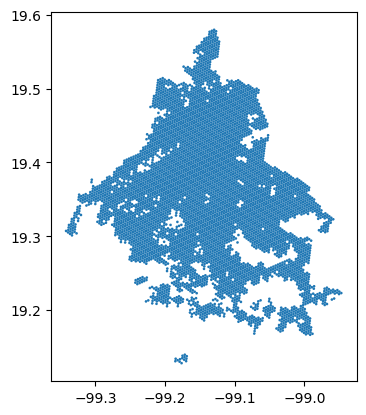

In [4]:
# Select source (res9)
hex_pop = gpd.GeoDataFrame()
hex_schema = 'censo'
hex_folder = 'hex_censo_mza_2020_res9'

if city == 'ZMVM':
    # Downloads hexagons corresponding to CDMX only
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"hex_id_9\" IN {hex_ids}"
else:
    # Downloads hexagons within 'city'
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"metropolis\" LIKE \'{city}\'"
    
hex_pop = aup.gdf_from_query(query, geometry_col='geometry')

print(hex_pop.shape)
hex_pop.head(2)
hex_pop.plot()

### Donwload nodes (Based on city)

In [5]:
#Folder names from database
nodes_schema = 'prox_analysis'
nodes_table = 'nodes_proximity_2020'

if city == 'ZMVM':
    query = f"SELECT * FROM {nodes_schema}.{nodes_table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
else:
    query = f"SELECT * FROM {nodes_schema}.{nodes_table} WHERE \"metropolis\" LIKE \'{city}\'"

nodes = aup.gdf_from_query(query, geometry_col='geometry')

print(nodes.shape)
nodes.head(2)

(7932239, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,2312249109,-99.104647,19.408315,POINT (-99.10465 19.40832),37.839976,sip_teatro,ZMVM
1,3438518377,-99.104268,19.410703,POINT (-99.10427 19.41070),40.377199,sip_teatro,ZMVM


### Download hexagons res9 (Based on city)

In [6]:
res = 9
folder = 'hexgrid'
table = f'hexgrid_{res}_city'

if city == 'ZMVM':
    hex_res_9 = hexgrid_9_cdmx.copy()
else:
    query = f"SELECT * FROM {folder}.{table} WHERE \"metropolis\" LIKE \'{city}\'"
    hex_res_9 = aup.gdf_from_query(query, geometry_col='geometry')
    hex_res_9 = hex_res_9[[f'hex_id_{res}','geometry','metropolis']]

print(hex_res_9.shape)
hex_res_9.head(2)

(12327, 4)


,hex_id_9,CVEGEO,metropolis,geometry
0,894995b802bffff,09002,ZMVM,"POLYGON ((-99.14365 19.46352, -99.14240 19.465..."
1,894995b8883ffff,09002,ZMVM,"POLYGON ((-99.18212 19.50165, -99.18417 19.501..."


## Data treatment

### Remove duplicate nodes

Creates nodes keeping osmid, geometry and metropolis (without duplicates) to store times to each amenity source by node in following loop.

In [7]:
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','metropolis']].copy()
print(nodes_geom.shape)
nodes_geom.head(2)

(188833, 3)


,osmid,geometry,metropolis
2037003,343301223,POINT (-99.22010 19.41119),ZMVM
2039718,7870105774,POINT (-99.23294 19.40947),ZMVM


### Reorganize previous times in rows to times from each node

Organize data by nodes by changing (time to source amenities) from rows (1 column with source amenity name + 1 column with time data) to columns (1 column with time data named after its source amenity)

In [ ]:
nodes_analysis = nodes_geom.copy()

for source_amenity in list(nodes.amenity.unique()):
    nodes_tmp = nodes.loc[nodes.amenity == source_amenity,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':source_amenity})
    # Search for amenities that aren't present in the city (with all values marked as 0) and change them to NaN
    if nodes_tmp[source_amenity].mean() == 0:
        nodes_tmp[source_amenity] = np.nan
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')
    
print(nodes_analysis.shape)
nodes_analysis.head(2)

## Proximity analysis

### Parameters definitions

In [ ]:
#{Eje (e):
#         {Amenidad (a):
#                       {Source (s))}}}

idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                         'Primaria':['denue_primaria'],
                         'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                       'Guarderías':['denue_guarderias'],
                                       'Asistencia social':['denue_dif']},
              'Comercio':{'Alimentos':['denue_supermercado','denue_abarrotes',
                                       'denue_carnicerias','sip_mercado'],
                          'Personal':['denue_peluqueria'],
                          'Farmacias':['denue_farmacias'],
                          'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                          'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                             'denue_lavanderia','denue_revistas_periodicos',
                                             'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                           'denue_bares','denue_cafe'],
                                'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                    'sip_espacio_publico','denue_parque_natural'],
                                'Cultural':['denue_cines','denue_museos']} 
             }

#If weight of amenity is less than number of sources, the algorith chooses the minimum time to source. Else (if equall or greater), chooses max time.
wegiht_idx = {'Escuelas':{'Preescolar':1,
                        'Primaria':1,
                        'Secundaria':1},
            'Servicios comunitarios':{'Salud':1,
                                    'Guarderías':1,
                                    'Asistencia social':1},
            'Comercio':{'Alimentos':1,
                        'Personal':1,
                        'Farmacias':1,
                        'Hogar':1,
                        'Complementarios':1},
            'Entretenimiento':{'Social':4,
                                'Actividad física':1,
                                'Cultural':1}
            }

### Fill missing columns (In case there is a source amenity not available in a city)

In [ ]:
sources = []

# Gather all possible sources
for eje in idx_15_min.keys():
    for amenity in idx_15_min[eje].values():
        for source in amenity:
            sources.append(source)

# If source not in currently analized city, fill column with np.nan
column_list = list(nodes_analysis.columns)

missing_sourceamenities = []

for s in sources:
        if s not in column_list:
            nodes_analysis[s] = np.nan
            missing_sourceamenities.append(a)

print("There are {} non present source amenities in {}".format(len(missing_sourceamenities),city))
missing_sourceamenities

## Proximity analysis - Max time calculation

In [ ]:
# time by ammenity

column_max_all = [] # list with all max index column names
column_max_ejes = [] # list with ejes index column names

#Goes through each eje in dictionary:
for e in idx_15_min.keys():
    
    #Appends to 3 lists currently examined eje
    column_max_all.append('max_'+ e.lower())
    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje
    
    #Goes through each amenity of current eje:
    for a in idx_15_min[e].keys():
        
        #Appends to 2 lists currently examined amenity:
        column_max_all.append('max_'+ a.lower())
        column_max_amenities.append('max_'+ a.lower())

        #Calculates time to currently examined amenity:
        #If weight is less than number of sources of amenity, choose minimum time to sources.
        if wegiht_idx[e][a] < len(idx_15_min[e][a]): 
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].min(axis=1)
        #Else, choose maximum time to sources.
        else:
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].max(axis=1)
    
    #Calculates time to currently examined eje (max time of its amenities):
    nodes_analysis['max_'+ e.lower()] = nodes_analysis[column_max_amenities].max(axis=1) 

index_column = 'max_time' # column name for maximum time data

#Add to column_max_all list the attribute 'max_time'
column_max_all.append(index_column)

#Assigns "max_time" the max time for all ejes
nodes_analysis[index_column] = nodes_analysis[column_max_ejes].max(axis=1) 

In [ ]:
nodes_analysis.head(2)

In [ ]:
#Add to column_max_all list the attributes 'osmid' and 'geometry' to filter nodes_analysis with the column_max_all list.
column_max_all.append('osmid')
column_max_all.append('geometry')
nodes_analysis_filter = nodes_analysis[column_max_all].copy()
nodes_analysis_filter.head(2)

### Group times by hexagons

In [ ]:
# group data by hex
res = 9
hex_tmp = hex_pop[['hex_id_9','geometry']]
hex_res_9_idx = aup.group_by_hex_mean(nodes_analysis_filter, hex_tmp, res, index_column)
hex_res_9_idx = hex_res_9_idx.loc[hex_res_9_idx[index_column]>0].copy()

# Review result
hex_res_9_idx.head(2)

In [ ]:
hex_res_9_idx.plot('max_time',cmap = 'viridis_r')

### Re-calculate max times by hexagon

In [ ]:
# recalculates max time to each eje from max times to calculated amenities and max_time from max eje

column_max_ejes = [] # list with ejes index column names

#Goes (again) through each eje in dictionary:
for e in idx_15_min.keys():
    
    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje
    
    #Goes (again) through each amenity of current eje:    
    for a in idx_15_min[e].keys():
        
        column_max_amenities.append('max_'+ a.lower())
        
    #Re-calculates time to currently examined eje (max time of its amenities):        
    hex_res_9_idx['max_'+ e.lower()] = hex_res_9_idx[column_max_amenities].max(axis=1)

hex_res_9_idx[index_column] = hex_res_9_idx[column_max_ejes].max(axis=1)

#Add to column_max_all list the attribute 'max_time'
column_max_ejes.append(index_column)

#Review results:
hex_res_9_idx.head(2)

## Proximity analysis - Index, median and mean calculation

In [ ]:
k = aup.sigmoidal_function_constant(15, 30)
k

In [ ]:
aup.sigmoidal_function(0.1464814753435666, 1000, 30)

In [ ]:
def apply_sigmoidal(x):
    if x == -1:
        return -1
    elif x > 1000:
        return 0
    else:
        val = aup.sigmoidal_function(0.1464814753435666, x, 30)
        return val

In [ ]:
amenities_col = ['max_preescolar','max_primaria','max_secundaria',
               'max_salud','max_guarderías','max_asistencia social',
               'max_alimentos','max_personal','max_farmacias','max_hogar',
               'max_complementarios','max_social','max_actividad física',
               'max_cultural']
for ac in amenities_col:
    idx_col = ac.replace('max','idx')
    hex_res_9_idx[idx_col] = hex_res_9_idx[ac].apply(apply_sigmoidal)

In [ ]:
idx_colname = []

for ac in amenities_col:
    idx_col = ac.replace('max','idx')
    idx_colname.append(idx_col)

idx_colname

In [ ]:
hex_res_9_idx['mean_time'] = hex_res_9_idx[amenities_col].mean(axis=1)
hex_res_9_idx['median_time'] = hex_res_9_idx[amenities_col].median(axis=1)
hex_res_9_idx['idx_sum'] = hex_res_9_idx[idx_colname].sum(axis=1)

## Aditional data and formating

### Add pop data

In [ ]:
# calculate population density
hex_pop = hex_pop.to_crs("EPSG:6372")
hex_pop['dens_pobha'] = hex_pop['pobtot'] / (hex_pop.area/10000)
hex_pop = hex_pop.to_crs("EPSG:4326")

In [ ]:
pop_list = ['hex_id_9','pobtot','dens_pobha']
hex_res_9_idx = pd.merge(hex_res_9_idx, hex_pop[pop_list], on='hex_id_9')

### Add city data

In [ ]:
hex_res_9_idx['city'] = city

## Format

In [ ]:
final_column_ordered_list = ['hex_id_9', 'geometry', 
                             'max_escuelas', 'max_preescolar', 'max_primaria', 'max_secundaria',
                             'max_servicios comunitarios', 'max_salud', 'max_guarderías', 'max_asistencia social',
                             'max_comercio', 'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar', 'max_complementarios',
                             'max_entretenimiento', 'max_social', 'max_actividad física', 'max_cultural', 
                             'idx_preescolar', 'idx_primaria', 'idx_secundaria',
                             'idx_salud', 'idx_guarderías', 'idx_asistencia social',
                             'idx_alimentos', 'idx_personal', 'idx_farmacias', 'idx_hogar', 'idx_complementarios',
                             'idx_social', 'idx_actividad física', 'idx_cultural',
                             'mean_time', 'median_time', 'max_time', 'idx_sum',
                             'pobtot', 'dens_pobha','city']

hex_res_9_idx_reordered = hex_res_9_idx[final_column_ordered_list]
hex_res_9_idx_reordered.head(2)

## Save to Database

In [ ]:
if save_todb:
    aup.gdf_to_db_slow(hex_res_9_idx_reordered,"proximityanalysis_hexres9_cdmx", 'prox_analysis', if_exists='replace')